# Practical work 5: edge detection

The goal of this practial work is to experiment various edge detectors. Attention is given to the following points:
1. comparison between the first and second order detectors
2. study of the impact of smoothing
3. removing non maxima answers of the detectors
4. evaluation in term of robustness and localization

In [1]:
# Useful modules
import numpy as np
from PIL import Image
from scipy.signal import convolve2d
import matplotlib.pyplot as plt

# Useful functions for this work
def orientation(Ix, Iy, Ig):
    """ Array[n,m]**3 -> Array[n,m]
        Returns an image of orientation.
    """
    n, m = Ix.shape
    x = np.arange(4)*np.pi/4
    ori = np.stack((np.cos(x), np.sin(x)), axis=1)
    O = np.zeros(Ix.shape)
    for i in range(n):
        for j in range(m):
            if Ig[i, j] > 0:
                v = np.array([Ix[i, j], -Iy[i, j]])/Ig[i, j]
                if Iy[i, j] > 0: v = -v
                prod = np.matmul(ori, v)
                maxi = prod.max()
                imax = np.nonzero(prod == maxi)
                O[i, j] = imax[0][0]+1
    return O

def gaussianKernel(sigma):
    """ double -> Array
        return a gaussian kernel of standard deviation sigma
    """
    n2 = int(np.ceil(3*sigma))
    x,y = np.meshgrid(np.arange(-n2,n2+1),np.arange(-n2,n2+1))
    kern =  np.exp(-(x**2+y**2)/(2*sigma*sigma))
    return kern/kern.sum()


def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def imshow_hot(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.hot()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def niceDisplay14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
        display from 1 up to 4 images or vectors with optionnal titles
        2D arrays are displayed as image with imshow()
        1D arrays are displayed as curve with plot()
    """
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
        
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()

In [2]:
def imageZeroPad(I,h):
    I_copy = I.copy()
    nb_line2add = h.shape[0]//2
    for i in range(nb_line2add):
        m = I_copy.shape[1]
        line = np.zeros(m)
        I_copy = np.vstack((I_copy,line))
        I_copy = np.vstack((line,I_copy))

        n = I_copy.shape[0]
        col = np.zeros(n).reshape((n,1))
        I_copy = np.hstack((I_copy,col))
        I_copy = np.hstack((col,I_copy))
    return I_copy

def imageCopyPad(I, h):
    I_copy = I.copy()
    nb_line2add = h.shape[0]//2
    for i in range(nb_line2add):
        line_t = I_copy[0,:]
        line_b = I_copy[-1,:]
        I_copy = np.vstack((line_t,I_copy))
        I_copy = np.vstack((I_copy,line_b))

        col_l = I_copy[:,0].reshape(-1, 1)
        col_r = I_copy[:,-1].reshape(-1, 1)
        I_copy = np.hstack((I_copy,col_r))
        I_copy = np.hstack((col_l,I_copy))
    return I_copy

## Exercice 1: comparison between first and second order detectors
The function `conv2()`, written in TME4, is a little bit slow. We propose to use `convolve2d()` available in module `scipy.signal`. We use this fonction with parameter `mode` set to `'same'` (see `help(convolve2d)`).

1. **Sobel filters** are a couple of filters approximating, by finite difference, the gradient of an image, and defined by: $$S_x = \begin{pmatrix} 1&0&-1 \\ 2&0&-2 \\ 1&0&-1 \end{pmatrix}\qquad S_y = \begin{pmatrix} 1&2&1 \\ 0&0&0 \\ -1&-2&-1 \end{pmatrix} $$ Write a function `SobelDetector(I,s)` that computes gradient of $I$, the norm of the gradient, and returns the norm threshold with a value $s$. 

In [3]:
def SobelFilter(I):
    S_x = np.array([[1,0,-1], [2, 0, -2], [1, 0, -1]])
    S_y = S_x.T
    padded_I = imageCopyPad(I,S_x)
    I_x = convolve2d(padded_I, S_x,  mode='same')
    I_y = convolve2d(padded_I, S_y,  mode='same')
    return I_x, I_y

def SobelDetector(I, s):
    """ Array*double -> Array """
    I_x, I_y = SobelFilter(I)
    norm_g = np.sqrt(I_x**2 + I_y**2)
    return np.where(norm_g>s, 1, 0)

2. **Laplacian filter** approximates, by finite difference, the seconde derivatives of an image. It is defined by: $$L=\begin{pmatrix} 0&1&0\\1&-4&1\\0&1&0 \end{pmatrix}$$ Write a function `LaplacianDetector(I,s)` that computes the Laplacian of $I$ and returns the zero crossings of the Laplacian as an image. Zero crossing occurs if the sign of Laplacian changes in a neighborrow. To identify a zero crossing for a pixel $(i,j)$:
 - consider a $3\times3$ neighborrow $I_L$ and compute the minimal and maximal values over $I_L$,
 - zero crossing occurs if $\max(I_L)>0$, $\min(I_L)<0$, and $\max(I_L)-\min(I_L)>s$

In [4]:
def check_zero_crossing_neighborhood(neighborhood, s):
    max_I_L = np.max(neighborhood)
    min_I_L = np.min(neighborhood)
    if max_I_L > 0 and min_I_L < 0 and max_I_L - min_I_L > s:
        return True
    else:
        return False

def to_zero_crossing(I, s):
    n,m = I.shape
    I_copy = np.zeros_like(I)
    for i in range(1, n):
        for j in range(1, m):
            neighborhood = I[   i - 1 : i +1,
                                j - 1 : j + 1]
            if check_zero_crossing_neighborhood(neighborhood, s):
                I_copy[i,j] = 1
    return I_copy

def LaplacienFilter(I):
    L = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    padded_I = imageCopyPad(I, L)
    return convolve2d(padded_I, L)

def LaplacianDetector(I, s):
    """ Array*double -> Array """
    I_L = LaplacienFilter(I)
    return to_zero_crossing(I_L, s)

3. **Comparison between first and second order detectors**. Experiment the two detectors on `img/lena.png`. Find the thresholds for both detectors (for example, 70 and 70) that allow to detect approximately the same edges.

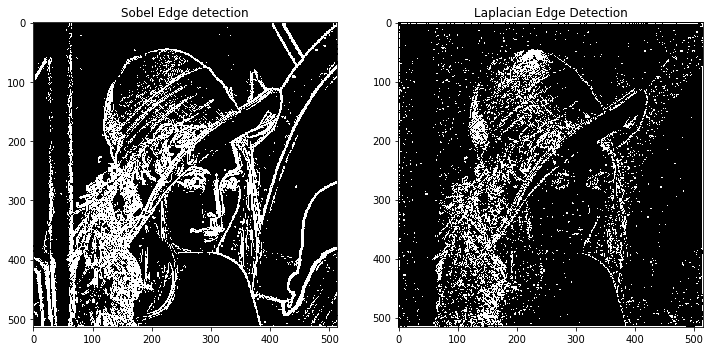

In [5]:
lena = np.array(Image.open('./img/lena.png'))

niceDisplay14([SobelDetector(lena, 70), LaplacianDetector(lena, 70)], ['Sobel Edge detection', 'Laplacian Edge Detection'])

**Le Laplacien a une meilleurs résolution spacial mais plus de bruit. Je vais essayer appliquer un filtre avant pour éviter cela.**

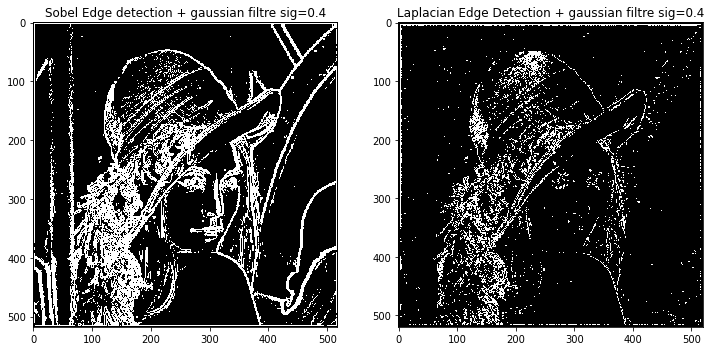

In [6]:
smooth_lena = convolve2d(lena, gaussianKernel(0.4))
niceDisplay14([SobelDetector(smooth_lena, 70), LaplacianDetector(smooth_lena, 70)], ['Sobel Edge detection + gaussian filtre sig=0.4', 'Laplacian Edge Detection + gaussian filtre sig=0.4'])

**On perd quand même pas mal de détail au niveau du visage mais moins de bruit :/**

## Exercice 2: Non maximum suppression

This exercice addresses the problem of a unique localization of edges from a map determined by first order filters. This can be obtained by applying a non maximum suppression technique: the norm of an edge gradient should be maxima in the direction of the gradient. To this end, we provide the function `orientation(Ix,Iy,Ig)` that determines from spatial derivatives $I_x$, $I_y$ (using your favorite filters) and the gradient norm $I_g$ the orientation of the gradient for each pixels. Possible orientations are $0$, $\frac\pi4$, $\frac\pi2$ and $\frac{3\pi}4$ respectively coded by values 1, 2, 3 and 4 (0 stands for null gradient). Orientation of gradient are determined in the direct orthonormal basis.

1. Display the output of function `orientation()` applied on image `img/tools.png`. Verify values according to the different local orientation configurations (use `imshow_hot()` in interactive mode in the nootebook to see pixels value pointed by the mouse screen).

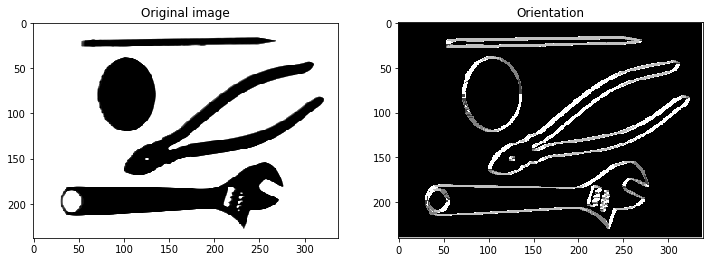

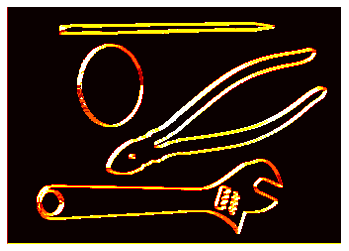

In [7]:
tools = np.array(Image.open('./img/tools.png'))
I_x, I_y = SobelFilter(tools)
I_g = np.sqrt(I_x**2 + I_y**2)
o = orientation(I_x, I_y, I_g)
img_to_display = [tools, o]
niceDisplay14(img_to_display, ['Original image', 'Orientation'])
imshow_hot(img_to_display[1])

Explain the different values given to a pixel by `orientation()`:

Your answer:

**On peut voir grace à la fonction `imshow_hot` l'orientation donnée au gradient en fonction de la couleur.**

**Par exemple pour le crayon, on peut voir toutes les valeurs à $3$ ce qui correspond à un angle de $\frac{\pi}{2}$**

2. Write a function `G=nms(Ig, Ior)` getting the gradient norm of an image, and the gradient orientation and returning an image of norm gradient for pixels being a local maxima of gradient norm in the direction of gradient or 0 otherwise. In other words, pixel `(i,j)` is a local maxima if `G[i,j] > 0` and `G[i,j]` gives the gradient norm value at this pixel.

In [8]:
def nms(Ig, Ior):
    """ Array**2 -> Array """
    n, m = Ig.shape
    Ig_copy = np.zeros_like(Ig)
    for i in range(1, n-1):
        for j in range(1, m-1):
            if Ior[i,j] == 1:
                local = Ig[i,j-1:j+2]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 2:
                local = np.array([Ig[i-1,j-1], Ig[i, j], Ig[i+1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 3:
                local = Ig[i-1:i+2, j]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 4:
                local = np.array([Ig[i+1,j-1], Ig[i, j], Ig[i-1, j+1]])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
    return Ig_copy

3. Experiments function `nms()` on images `img/tools.png` and `img/lena.png` after apply or not a gaussian filter (use the function `gaussianKernel()` given in the previous TME).


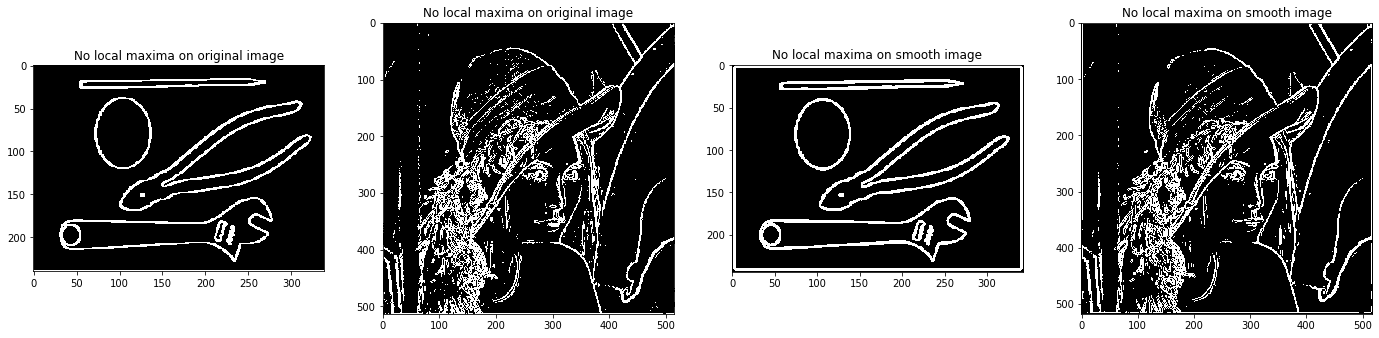

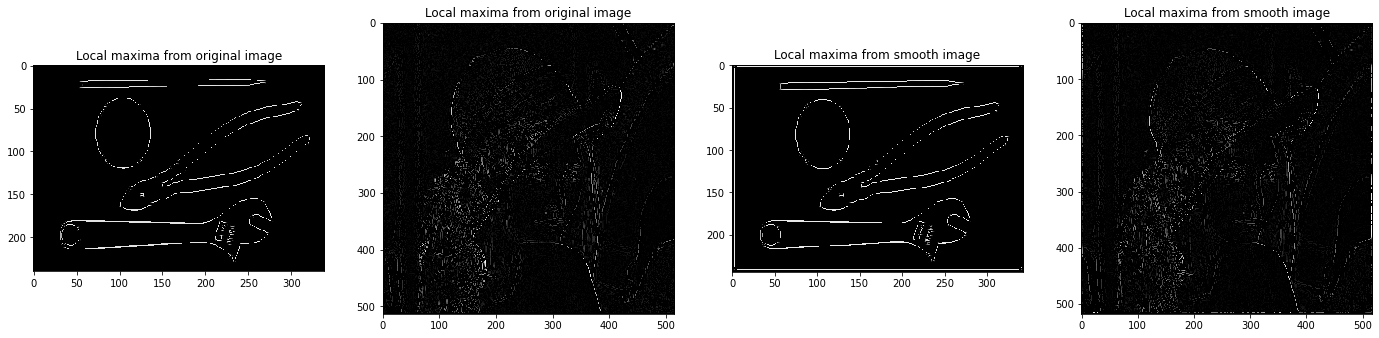

In [9]:
tools = np.array(Image.open('./img/tools.png'))
lena = np.array(Image.open('./img/lena.png'))
smooth_tools = convolve2d(tools, gaussianKernel(0.5))
smooth_lena = convolve2d(lena, gaussianKernel(0.5))
img_to_display = []
title_to_display = ["Local maxima from original image", "Local maxima from original image", "Local maxima from smooth image", "Local maxima from smooth image"]
for img in [tools, lena, smooth_tools, smooth_lena]:
    I_x, I_y = SobelFilter(img)
    I_g = np.sqrt(I_x**2 + I_y**2)
    o = orientation(I_x, I_y, I_g)
    img_to_display.append(nms(I_g, o))
niceDisplay14([SobelDetector(tools, 100), SobelDetector(lena, 100), SobelDetector(smooth_tools, 100), SobelDetector(smooth_lena, 100)], ['No local maxima on original image', 'No local maxima on original image','No local maxima on smooth image', 'No local maxima on smooth image'])
niceDisplay14(img_to_display, title_to_display)

4. Conclude on the effect of smoothing (value of $\sigma$) on the edge detection process and on the size of edges.

- **Sans maxima : Le filtre gaussien permet de réduire le bruit mais épaissi les bords; On perd en résolution spacial**
- **Avec maxima : On ne remarque plus de différence induite apr le filtre. Le maxima réduit efficacement la taille des bords. Même parfois un peu trop, est-ce que ça changerai quelque chose d'agrandir le voisinage ?**

**Test d'agrandir le voisinage**

In [10]:
list(range(-2, 2))

[-2, -1, 0, 1]

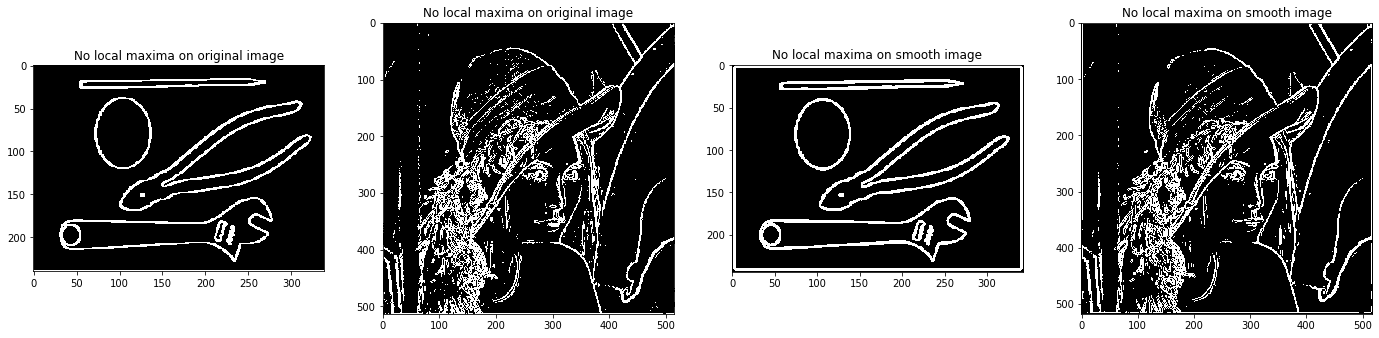

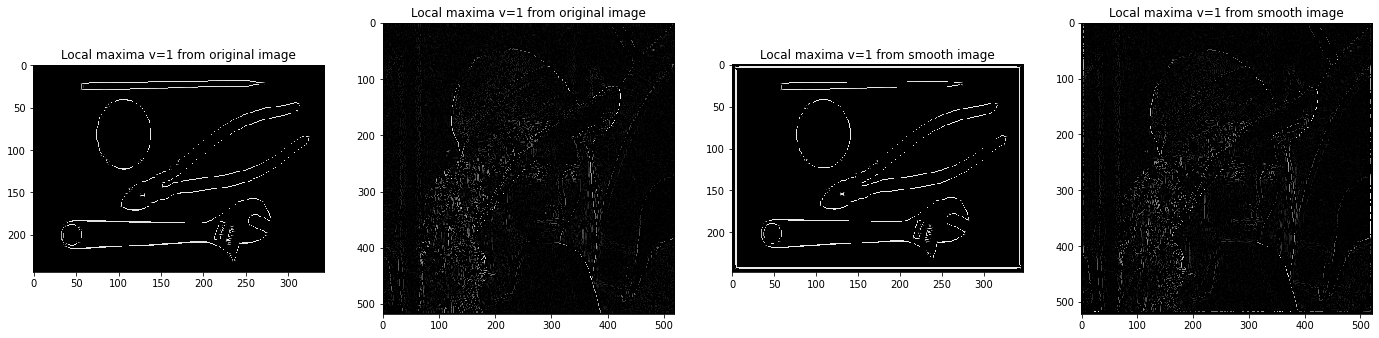

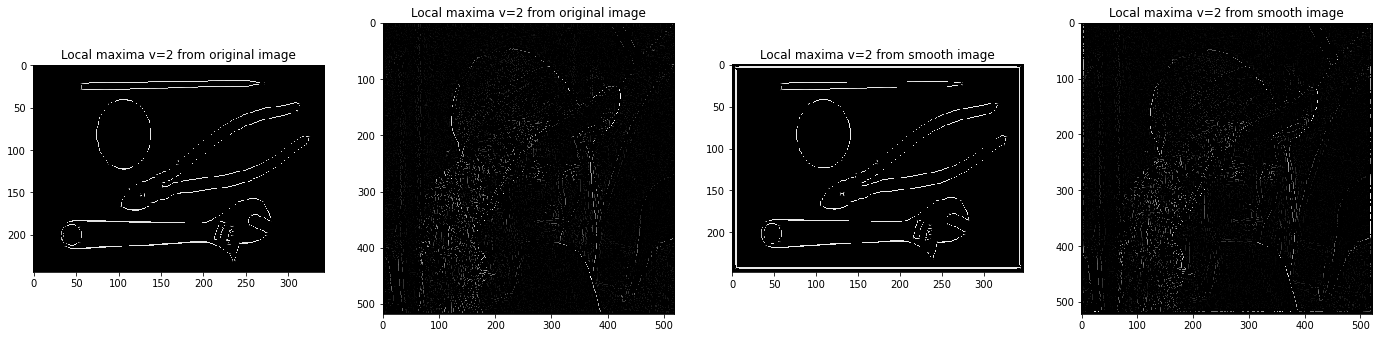

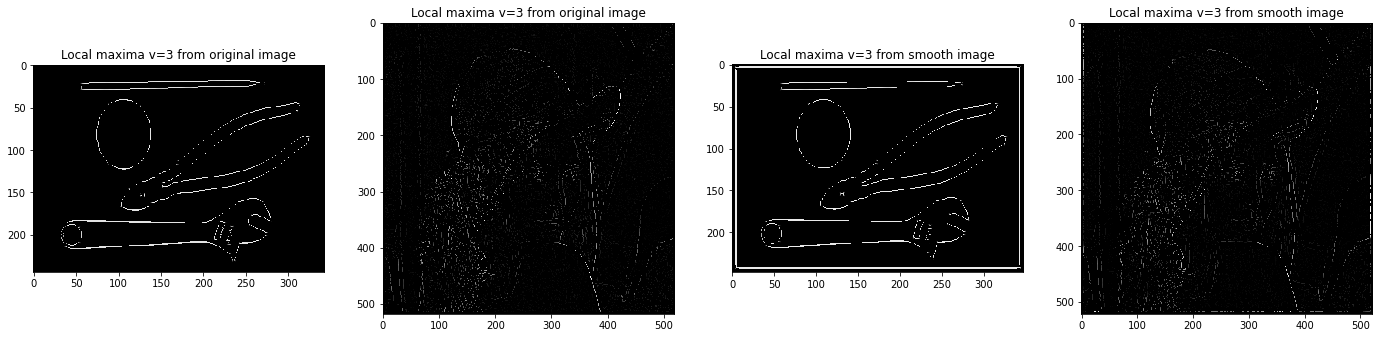

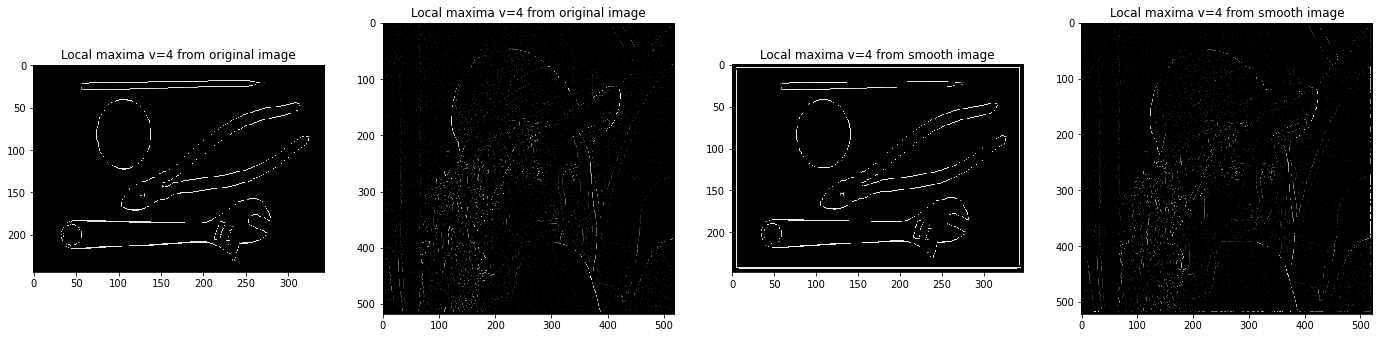

In [11]:
def nms(Ig, Ior, v):
    """ Array**2, int -> Array """
    n, m = Ig.shape
    Ig_copy = np.zeros_like(Ig)
    for i in range(1+v, n-v):
        for j in range(1+v, m-v):
            if Ior[i,j] == 1:
                local = Ig[i,j-v:j+v+1]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 2:
                local = np.array([Ig[i+k,j+k] for k in range(-v, v+1)]) 
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 3:
                local = Ig[i-v:i+v+1, j]
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
            elif Ior[i,j] == 4:
                local = np.array([Ig[i-k,j+k] for k in range(-v, v+1)])
                local_max = np.max(local)
                if Ig[i,j] == local_max:
                    Ig_copy[i,j] = Ig[i,j]
    return Ig_copy
tools = np.array(Image.open('./img/tools.png'))
lena = np.array(Image.open('./img/lena.png'))
smooth_tools = convolve2d(tools, gaussianKernel(0.5))
smooth_lena = convolve2d(lena, gaussianKernel(0.5))
niceDisplay14([SobelDetector(tools, 100), SobelDetector(lena, 100), SobelDetector(smooth_tools, 100), SobelDetector(smooth_lena, 100)], ['No local maxima on original image', 'No local maxima on original image','No local maxima on smooth image', 'No local maxima on smooth image'])
for v in [1,2,3,4]:
    img_to_display = []
    title_to_display = [f"Local maxima v={v} from original image", f"Local maxima v={v} from original image", f"Local maxima v={v} from smooth image", f"Local maxima v={v} from smooth image"]
    for img in [tools, lena, smooth_tools, smooth_lena]:
        img = imageCopyPad(img, np.zeros((5,5))) # On pad en plus sinon on a des problèmes de voisinage sur les bords
        I_x, I_y = SobelFilter(img)
        I_g = np.sqrt(I_x**2 + I_y**2)
        o = orientation(I_x, I_y, I_g)
        img_to_display.append(nms(I_g, o, v))
    niceDisplay14(img_to_display, title_to_display)

**Changer le voisinage n'a pas l'air de changer grand chose xD**

**Le fait que certain trait soit incomplet doit venir du fait que discrétiser en seulement 4 direction possible est trop faible !**

## Exercice 3:  Effects of smoothing in edge detection
Edge detectors are high pass filters and then amplify noise. To avoid this issue, we apply low pass filter, such as Gaussian filter, as preprocess. In this exercice, we use the image `img/lena.png`.

1. Smooth image `lena` by convolving with $G_\sigma$, the gaussian kernel of standard deviation $\sigma = 2$.

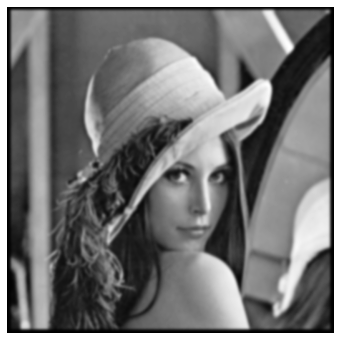

In [12]:
smooth_lena = convolve2d(lena, gaussianKernel(2))
imshow(smooth_lena)

2. On the smoothed image apply Sobel and Laplacian edge detectors. Find threshold values (around 10 for Laplacian and 200 for Sobel) in order the two detectors approximately detect the same contours. After smoothing, what are the main difference between the two detectors.

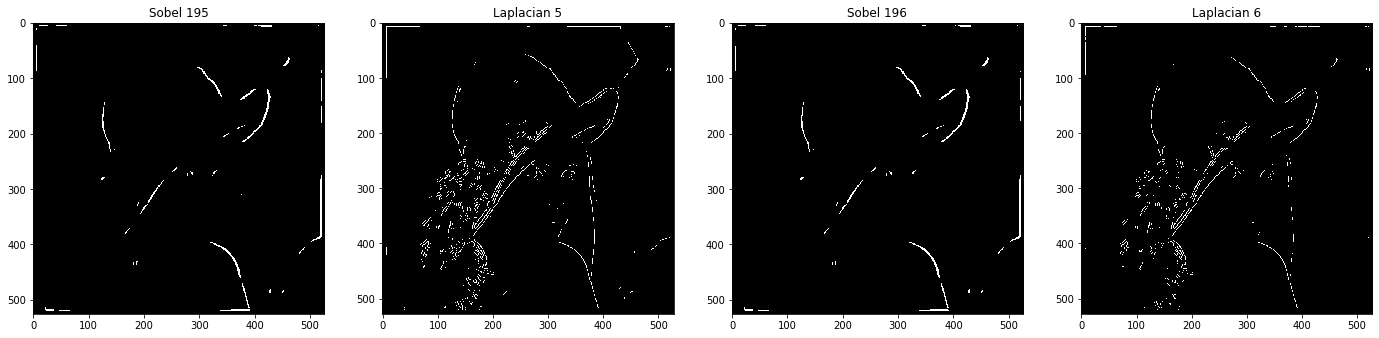

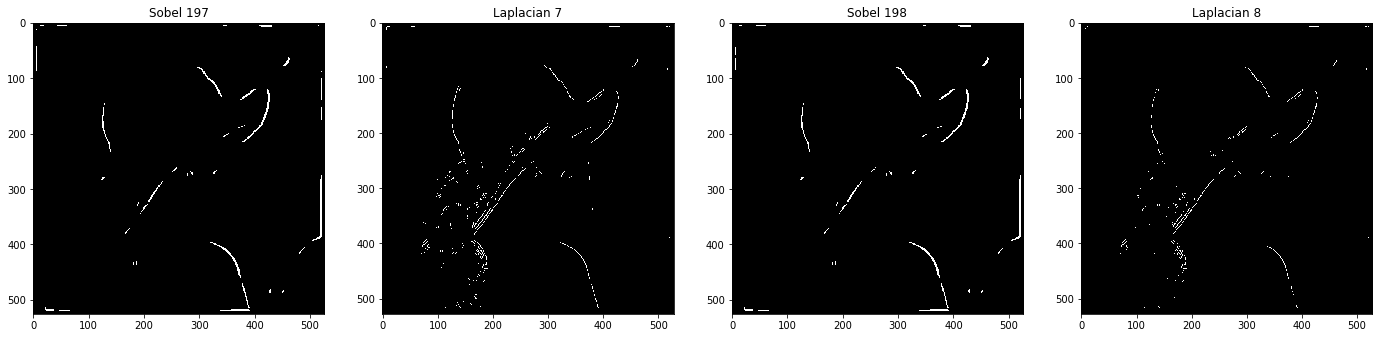

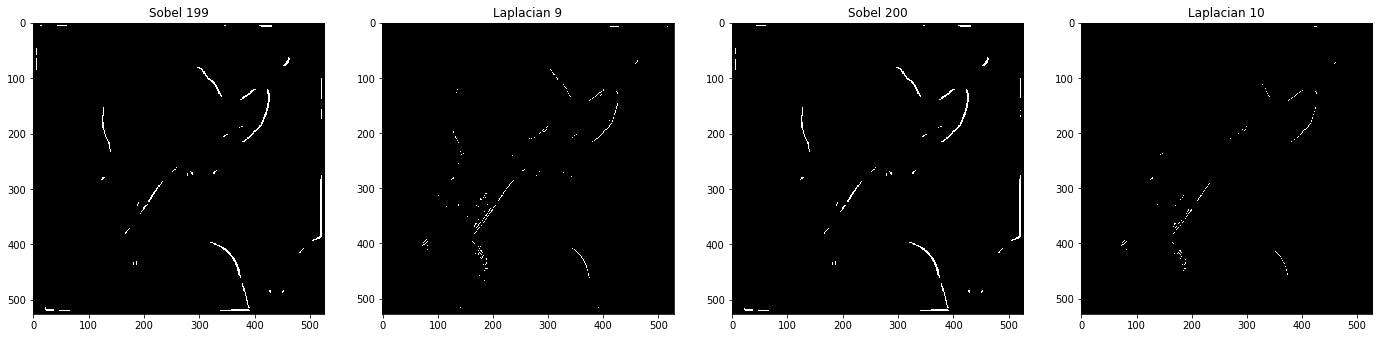

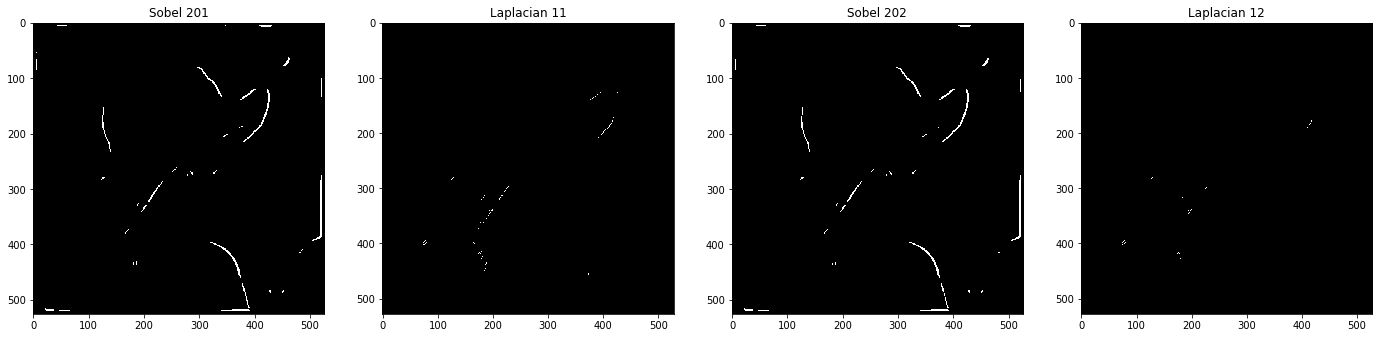

In [13]:
search_range = 5
img_to_display = []
title_to_display = []
for s_1, s_2 in zip(range(200 - search_range, 200 + search_range), range(10 - search_range, 10 + search_range)):
    img_to_display.append(SobelDetector(smooth_lena, s_1))
    title_to_display.append(f'Sobel {s_1}')

    img_to_display.append(LaplacianDetector(smooth_lena, s_2))
    title_to_display.append(f'Laplacian {s_2}')
for i in range(4, len(img_to_display), 4):
    niceDisplay14(img_to_display[i-4:i], title_to_display[i-4:i])

**Le Sobel change relativement peu sur cet intervale de seuil. Je propose le Sobel à 200 et le laplacien à 8.**

**Après un lissage, la principale différence entre ces deux filtrer est l'épaisseur des traits.**

3. Let vary $\sigma\in[\sigma_1, \sigma_2]$ ($\sigma_1$ and $\sigma_2$ to be determined) and analyze results obtained for both detectors. What are the effects of smoothing on the noise ? on the localisation of contours ?

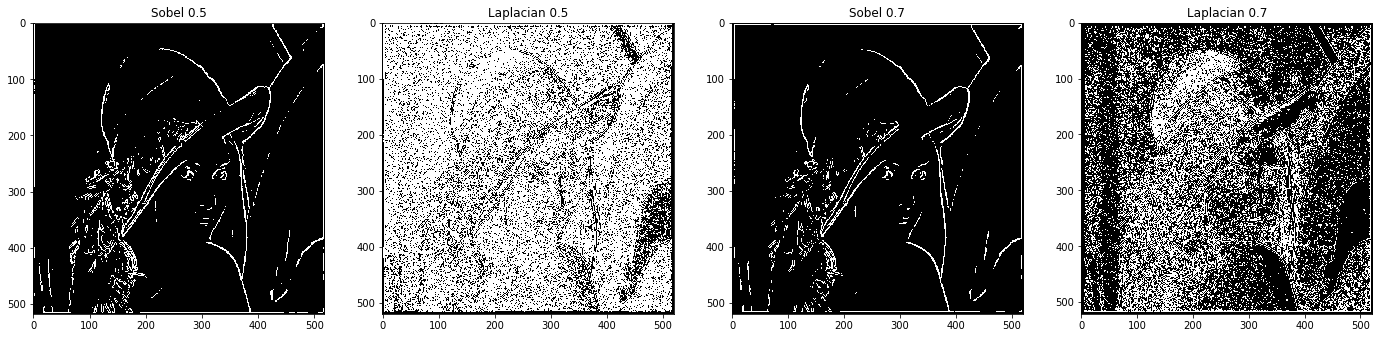

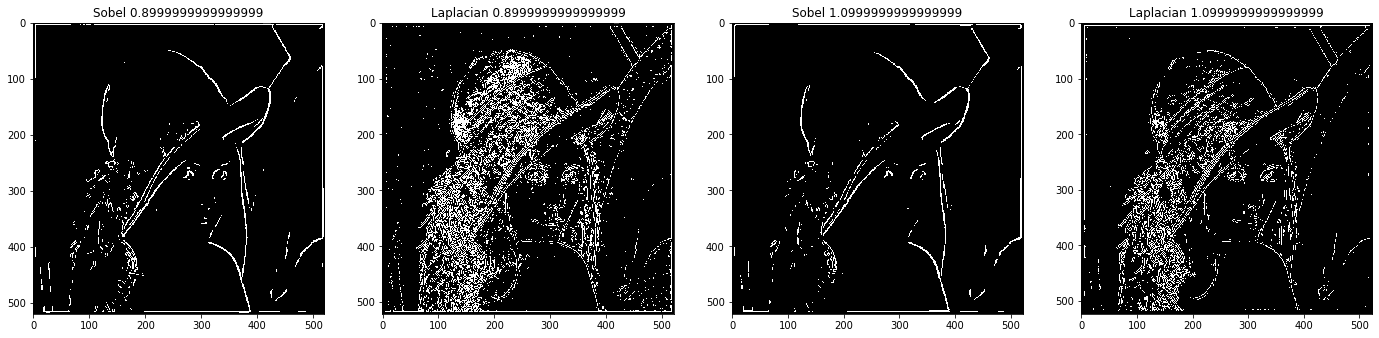

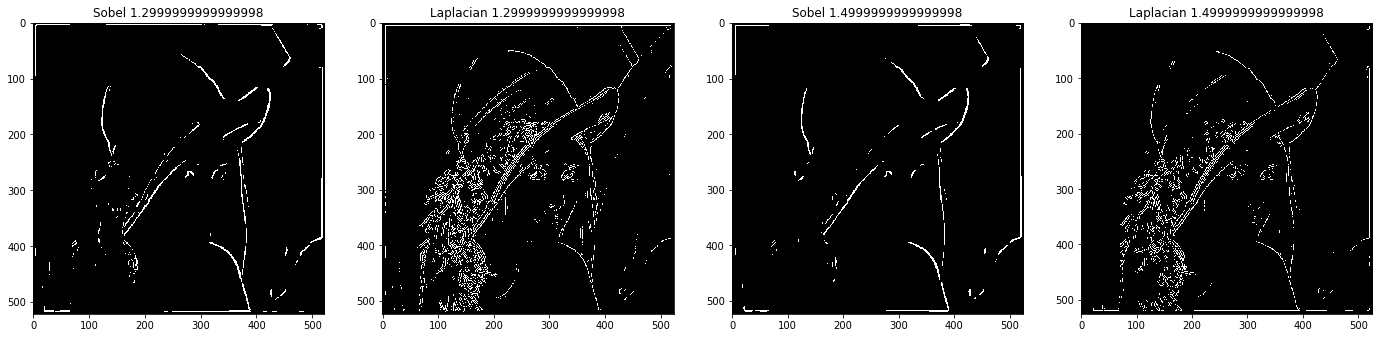

In [14]:
img_to_display = []
title_to_display = []
for sig in np.arange(0.5, 2, 0.2):
    smooth_lena = convolve2d(lena, gaussianKernel(sig))

    img_to_display.append(SobelDetector(smooth_lena, 200))
    title_to_display.append(f"Sobel {sig}")

    img_to_display.append(LaplacianDetector(smooth_lena, 8))
    title_to_display.append(f"Laplacian {sig}")

for i in range(4, len(img_to_display), 4):
    niceDisplay14(img_to_display[i-4:i], title_to_display[i-4:i])

**Le lissage réduit le bruit, surtout chez le second ordre, mais en revanche on perd en précision spacial surtout chez le Sobel**

4. Replace the gaussian filter by a constrast enhancer filter of impulse response $\begin{pmatrix} 0&-1&0\\-1&5&-1\\0&-1&0\end{pmatrix}$ (other choices are possible). Discuss the results.

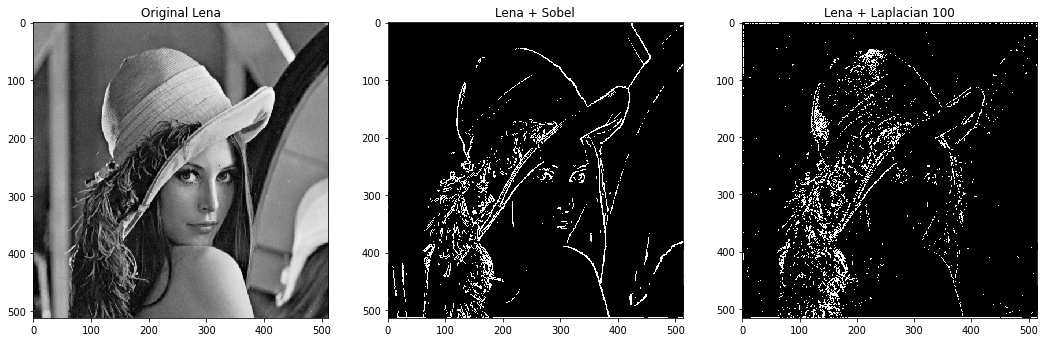

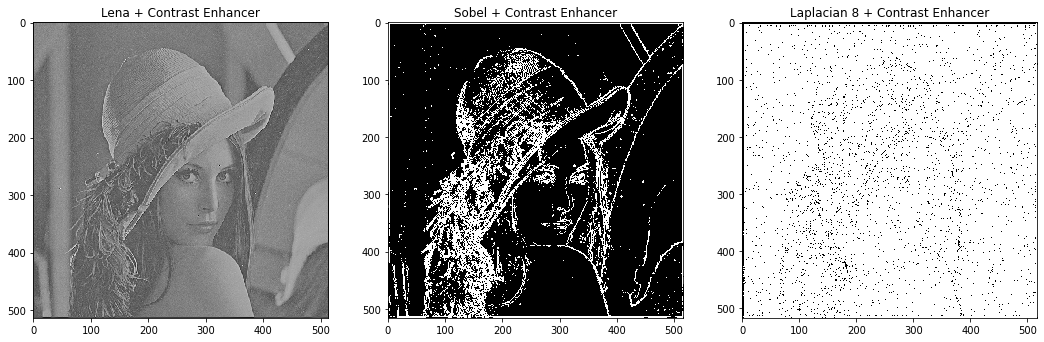

In [15]:
h = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
h_lena = convolve2d(lena, h)
niceDisplay14(  [lena, SobelDetector(lena, 200), LaplacianDetector(lena, 100)], 
                ['Original Lena',  'Lena + Sobel', 'Lena + Laplacian 100'])
niceDisplay14( [h_lena, SobelDetector(h_lena, 200), LaplacianDetector(h_lena, 8)], ['Lena + Contrast Enhancer', 'Sobel + Contrast Enhancer', 'Laplacian 8 + Contrast Enhancer'])

**On remarque qu'il faut changer la threshold pour le laplacien**

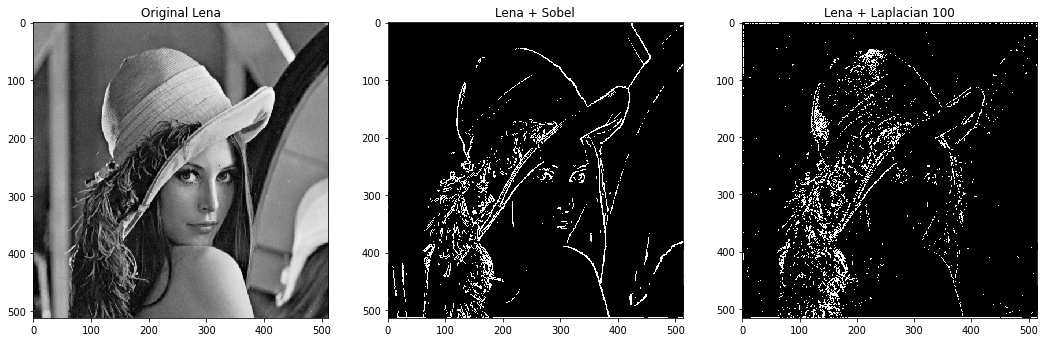

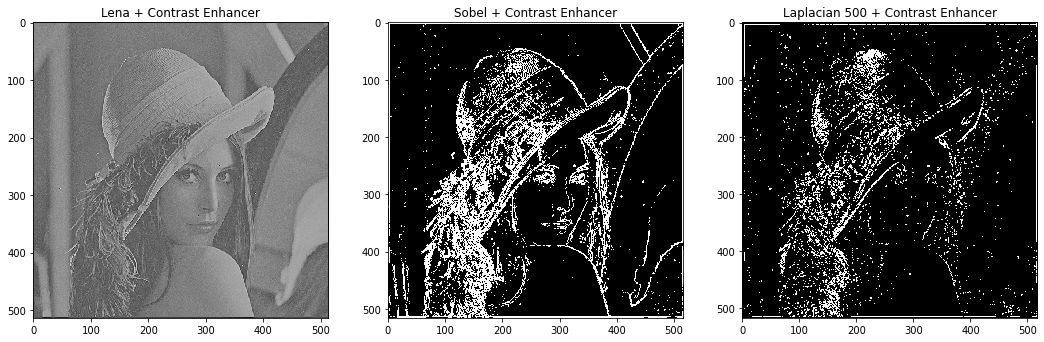

In [16]:
niceDisplay14(  [lena, SobelDetector(lena, 200), LaplacianDetector(lena, 100)], 
                ['Original Lena',  'Lena + Sobel', 'Lena + Laplacian 100'])
niceDisplay14( [h_lena, SobelDetector(h_lena, 200), LaplacianDetector(h_lena, 500)], ['Lena + Contrast Enhancer', 'Sobel + Contrast Enhancer', 'Laplacian 500 + Contrast Enhancer'])

- **On voit que pour un même seuil, le contrast enhancer facilite la detection de bord avec le Sobel**
- **On voit que pour un même seuil, le contrast enhancer à perdu le Laplacian, tout comme lorsqu'on a appliqué le filtre gaussien, un changement de seuil est nécessaire pour voir quelque chose**
- **Il est plus difficile de faire des comparaisons sur l'effet du contrast enhancer pour le Laplacian à cause du changement de seuil nécessaire, autrement en bricolant le seuil on peut retrouver des images similaires**

5. Apply a multiresolution decomposition up to a size $8\times8$. Apply the two detectors for each resolution. Discuss the results.

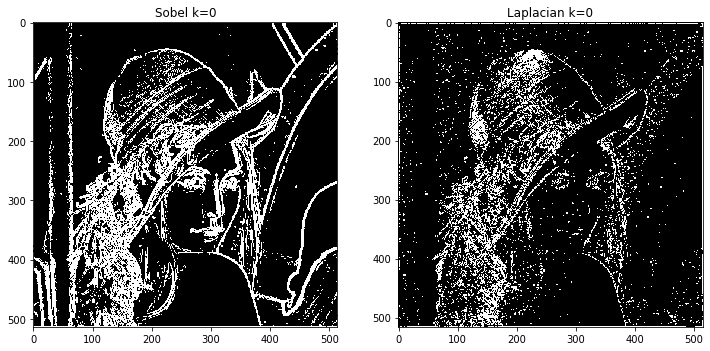

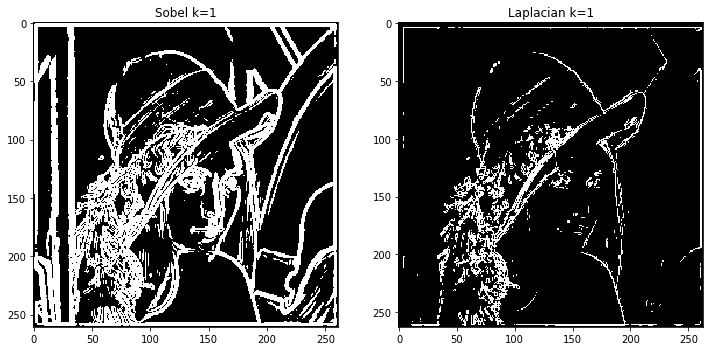

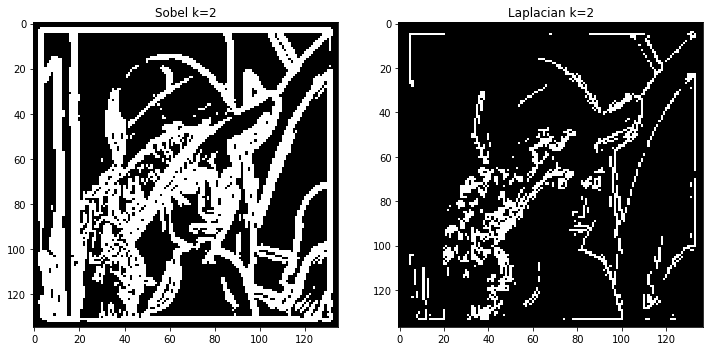

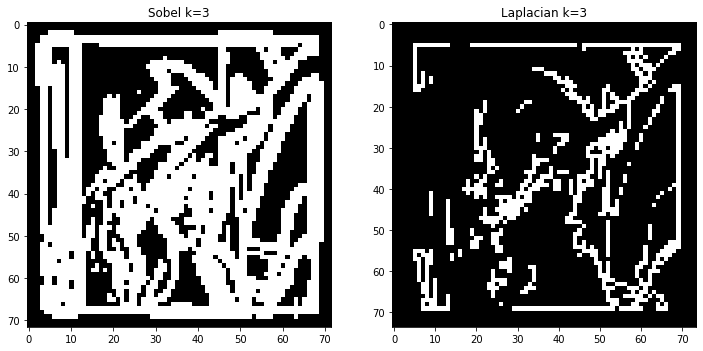

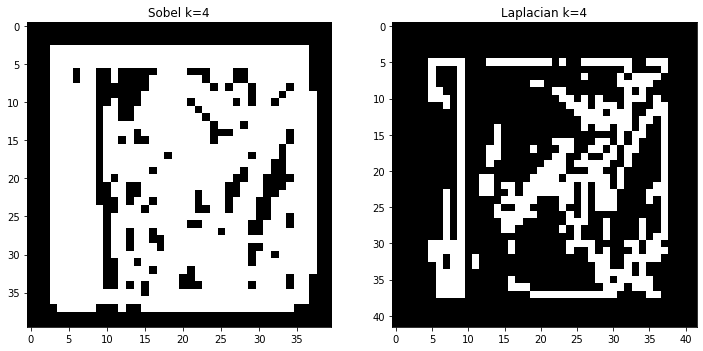

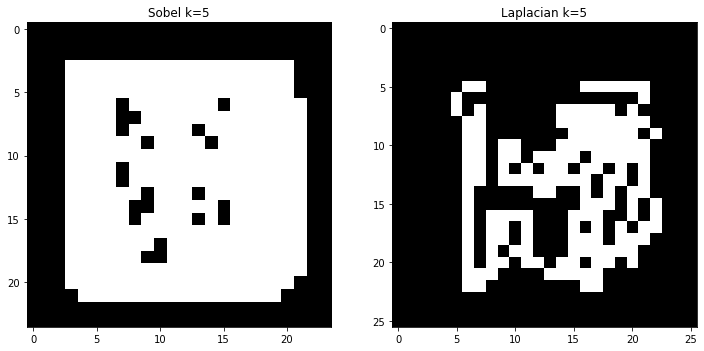

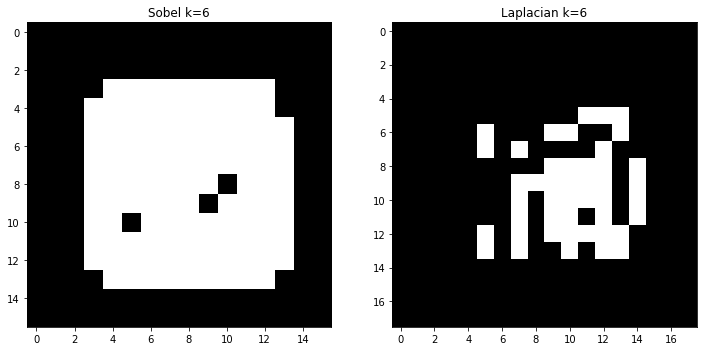

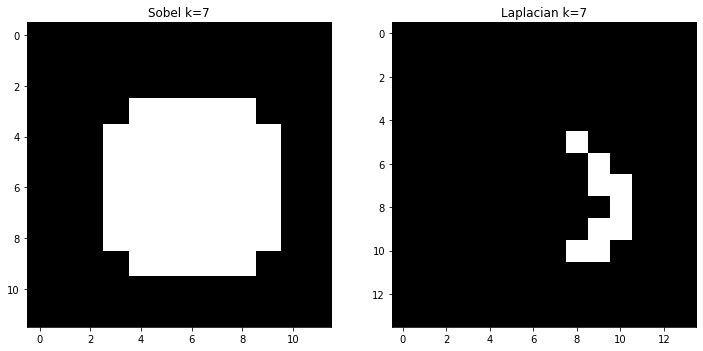

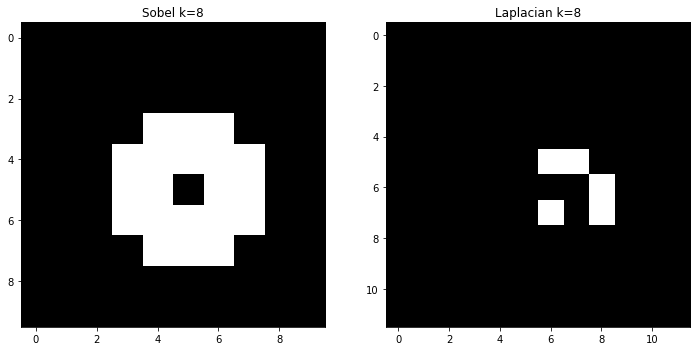

0

In [17]:
def subSample2(I):
    """ Array -> Array """
    return I[::2,::2]

def pyramidal(I_k, sigma, k):
    niceDisplay14(  [SobelDetector(I_k, 70), LaplacianDetector(I_k, 70)],
                    [f'Sobel k={k}', f'Laplacian k={k}'])
    if I_k.shape[0] == 8:
        return 0
    else:
        return pyramidal(
            subSample2(
                convolve2d(I_k, gaussianKernel(sigma))
            ),
            sigma,
            k+1
        )
pyramidal(lena, 1, 0)

**Deux phénomènes sont en jeux au fûr et à mesure des itérations :**

- **Dans un premier temps, le filtre gaussien voit son $\sigma$ augmenter. De faible valeur de $\sigma$ permette de detecter les bords fins, et à l'inverse, de grande valeur de $\sigma$ permettent de detecter les bord plus épais. Cela vient du fait que la matrice de filtre augmente en taille. => Bref par ce filtre on capture tous les bords, de toutes les tailles.**
- **Dans un second temps, le subsampling permet de raffiner la précision sur la localisation des bords.**